<a href="https://colab.research.google.com/github/zrruziev/Deep_Learning_Practice/blob/main/TDC/C4_W4_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

##Utilities

In [42]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

##Download and Preview the Dataset

In [43]:
# Wownload the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv


--2022-05-01 08:38:19--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 209.85.146.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2022-05-01 08:38:19 (80.7 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



In [44]:
# Preview the dataset
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


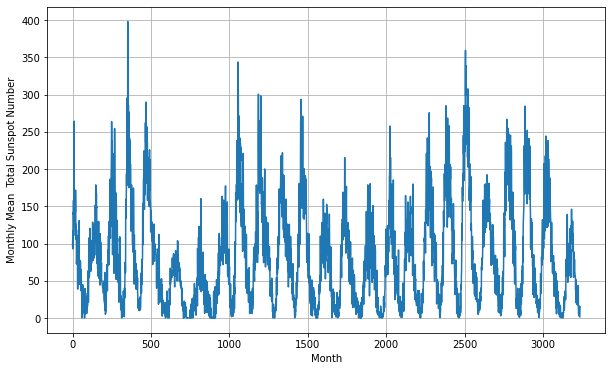

In [45]:
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        time_step.append(int(row[0]))
        sunspots.append(float(row[2]))

time = np.array(time_step)
series = np.array(sunspots)

plot_series(time, series, xlabel='Month',ylabel='Monthly Mean  Total Sunspot Number')

##Split the dataset

In [46]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

##Prepare Features and Labels

In [47]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [48]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

##Build the Model


In [49]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                992       
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


##Tune the Learning Rate

In [50]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(momentum=.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

In [51]:
# Train the model to find best learning rate
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 2s 9ms/step - loss: 62.0645 - mae: 62.5597 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 8ms/step - loss: 61.7964 - mae: 62.2922 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 8ms/step - loss: 61.4948 - mae: 61.9911 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 1s 9ms/step - loss: 61.1587 - mae: 61.6551 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 9ms/step - loss: 60.7834 - mae: 61.2795 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 8ms/step - loss: 60.3672 - mae: 60.8628 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 1s 9ms/step - loss: 59.9080 - mae: 60.4037 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 1s 9ms/step - loss: 59.4010 - mae: 59.8964 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 9ms/step - loss: 58.8449 - mae: 59.3403 

##Plot the learning rate and loss relationship

(1e-08, 0.001, 0.0, 100.0)

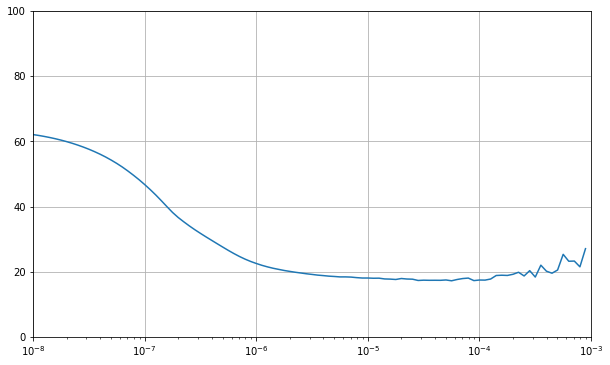

In [52]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.semilogx(history.history['lr'], history.history['loss'])
# plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8,1e-3, 0,100])

##Train the Model with choosen learning rate 

In [56]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [57]:
# Set the learning rate
learning_rate = 1e-5

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 2s 9ms/step - loss: 41.0666 - mae: 41.5618
Epoch 2/100
93/93 [==============================] - 1s 9ms/step - loss: 22.5615 - mae: 23.0559
Epoch 3/100
93/93 [==============================] - 1s 8ms/step - loss: 21.0843 - mae: 21.5784
Epoch 4/100
93/93 [==============================] - 1s 9ms/step - loss: 20.2365 - mae: 20.7302
Epoch 5/100
93/93 [==============================] - 1s 8ms/step - loss: 20.0930 - mae: 20.5865
Epoch 6/100
93/93 [==============================] - 1s 8ms/step - loss: 19.8487 - mae: 20.3422
Epoch 7/100
93/93 [==============================] - 1s 9ms/step - loss: 19.1775 - mae: 19.6716
Epoch 8/100
93/93 [==============================] - 1s 8ms/step - loss: 19.0668 - mae: 19.5605
Epoch 9/100
93/93 [==============================] - 1s 9ms/step - loss: 18.8542 - mae: 19.3477
Epoch 10/100
93/93 [==============================] - 1s 9ms/step - loss: 18.5906 - mae: 19.0843
Epoch 11/100
93/93 [===================

##Model Prediction


In [58]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

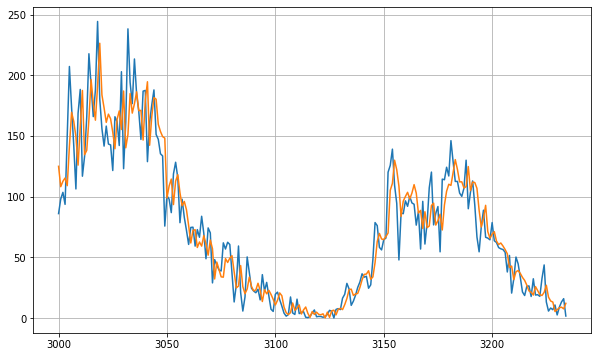

In [59]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [60]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())


14.783206
